# List of todos/questions


- Custom regularization on non-driver features?
- Interaction terms?
- Finished (what if they didn't finish?) we still have placement for them
- Finishing position or relative finishing position?


- There's no way to validate the usefulness of this until we through it into the predictive model

In [15]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler

In [16]:
def load_kaggle_data(path):
    data = pd.read_csv(path)
    data.replace({'\\N':np.nan}, inplace=True)
    return data

data_dir ='kaggle-data/'

circuits_raw_df = load_kaggle_data(f'{data_dir}/circuits.csv')
constructors_raw_df = load_kaggle_data(f'{data_dir}/constructors.csv')
constructor_standings_raw_df = load_kaggle_data(f'{data_dir}/constructor_standings.csv')
driver_standings_raw_df = load_kaggle_data(f'{data_dir}/driver_standings.csv')
drivers_raw_df = load_kaggle_data(f'{data_dir}/drivers.csv')
laptimes_raw_df = load_kaggle_data(f'{data_dir}/lap_times.csv')
pitstops_raw_df = load_kaggle_data(f'{data_dir}/pit_stops.csv')
qualifying_raw_df = load_kaggle_data(f'{data_dir}/qualifying.csv')
races_raw_df = load_kaggle_data(f'{data_dir}/races.csv')
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')
seasons_raw_df = load_kaggle_data(f'{data_dir}/seasons.csv')
sprint_results = load_kaggle_data(f'{data_dir}/sprint_results.csv')
status_raw_df = load_kaggle_data(f'{data_dir}/status.csv')

# print('circuits_raw_df', circuits_raw_df.columns)
# print('constructors_raw_df', constructors_raw_df.columns)
# print('constructor_standings_raw_df', constructor_standings_raw_df.columns)
# print('driver_standings_raw_df', driver_standings_raw_df.columns)
# print('drivers_raw_df', drivers_raw_df.columns)
# print('laptimes_raw_df', laptimes_raw_df.columns)
# print('pitstops_raw_df', pitstops_raw_df.columns)
# print('qualifying_raw_df', qualifying_raw_df.columns)
# print('races_raw_df', races_raw_df.columns)
# print('results_raw_df', results_raw_df.columns)
# print('seasons_raw_df', seasons_raw_df.columns)
# print('sprint_results', sprint_results.columns)
# print('status_raw_df', status_raw_df.columns)

In [17]:
drivers = drivers_raw_df[['driverId','forename','surname','number']].reset_index(drop=True)
drivers['Name'] = drivers[['forename', 'surname']].agg(' '.join, axis=1)
drivers.drop(['forename','surname'], axis=1, inplace=True)

driver_name_id_map = dict(zip(drivers['Name'], drivers['driverId']))
def get_driverID(name):
    
    return drivers.loc[drivers['Name']==name, 'driverId'].squeeze()

driver_name_number_map = dict(zip(drivers['Name'], drivers['number']))
def get_driver_number(name):
    
    return drivers.loc[drivers['Name']==name, 'number'].squeeze()


#drivers[drivers['Name'].str.contains('Nyck')]

driver_names_of_interest = ['Max Verstappen',
                           'Sergio Pérez',
                           'Lewis Hamilton',
                           'Fernando Alonso',
                           'Charles Leclerc',
                           'Lando Norris',
                           'George Russell',
                           'Oscar Piastri',
                           'Lance Stroll',
                           'Pierre Gasly',
                           'Esteban Ocon',
                           'Alexander Albon',
                           'Nico Hülkenberg',
                           'Valtteri Bottas',
                           'Guanyu Zhou',
                           'Yuki Tsunoda',
                           'Kevin Magnussen',
                           #'Liam Lawson',
                           'Logan Sargeant',
                           'Nyck de Vries',
                           'Daniel Ricciardo']
driver_ids_of_interest = [driver_name_id_map[name] for name in driver_names_of_interest]

driver_numbers_of_interest = [driver_name_number_map[name] for name in driver_names_of_interest]


In [18]:
# start with race results
# extend positionText labels (see Appendix)
results_raw_df['positionText'] = results_raw_df['positionText'].replace({'R':'Retired','D':'Disqualified','N':'not classified', 'E':'Excluded','W':'Withdrawn','F':'failed to qualify'})

# drop time, milliseconds, fastestLap, rank, fastestLapTime, fastestLapSpeed, and number (http://ergast.com/mrd/methods/results/)
races = results_raw_df.drop(['time','milliseconds','fastestLap','rank','fastestLapTime','fastestLapSpeed','number'], axis=1)
races.drop(['positionOrder'], axis=1, inplace=True)
races['position'].fillna('NaN', inplace=True)
#display(races.isna().sum())
assert races.isna().sum().sum() == 0, 'there are null values'

# Merge with drivers
prev_len = races.shape[0]
races = races.merge(drivers[['driverId','Name']], on='driverId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Name'].isna().sum() == 0


# Filter for drivers of interest
races = races[races['Name'].isin(driver_names_of_interest)].reset_index(drop=True)
assert races['driverId'].nunique() == len(driver_ids_of_interest), 'confirm we have lap data for all drivers of interest'
races.drop(['driverId'], axis=1, inplace=True)
assert races.groupby(['raceId','Name']).size().max() == 1, 'driver occurs twice in a race'

# Get status string
prev_len = races.shape[0]
races = races.merge(status_raw_df[['statusId','status']], on='statusId', how='left')
assert races['status'].isna().sum() == 0
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
races.drop(['statusId'], axis=1, inplace=True)


# Get car name
prev_len = races.shape[0]
constructors_raw_df.rename(columns={'name':'Car'}, inplace=True)
car_names = constructors_raw_df['Car'].unique()
races = races.merge(constructors_raw_df[['constructorId','Car']], on='constructorId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Car'].isna().sum() == 0
races.drop(['constructorId'], axis=1, inplace=True)

# Get race data (ignoring qualifying data)
races_raw_df.rename(columns={'name':'Race'}, inplace=True)
prev_len = races.shape[0]
races = races.merge(races_raw_df[['raceId','Race','round','circuitId','date']], on='raceId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0


# Get circuit data
prev_len = races.shape[0]
circuits_raw_df.rename(columns={'name':'Circuit'}, inplace=True)
circuits_raw_df['alt'].fillna(circuits_raw_df['alt'].median(), inplace=True) # impute median altitude -- #todo may want to change
races = races.merge(circuits_raw_df[['circuitId','Circuit','location','country','alt','lat','lng']], on='circuitId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0
races.drop(['circuitId'], axis=1, inplace=True)

# Explode date
races['date'] = pd.to_datetime(races['date'])
races['Month'] = races['date'].dt.month
races['Year'] = races['date'].dt.year
races.drop(['date'], axis=1, inplace=True)

# Get number of laps in the race
number_of_laps = results_raw_df[results_raw_df['statusId']==1].groupby(['raceId'])['laps'].max().reset_index(name='nlaps')
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
prev_len = races.shape[0]
races = races.merge(number_of_laps, on='raceId',how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
races.drop(['laps'], axis=1, inplace=True)


races
races['Year'].min()

2001

In [19]:
# Handle position
races['position'] = races['position'].astype(float)

# Fill in missing position with last place

# race_n_drivers = results_raw_df.groupby('raceId')['driverId'].nunique().reset_index(name='total_drivers_race')
# prev_len = races.shape[0]
# races = races.merge(race_n_drivers, on='raceId', how='left')
# assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'

# races['position'].fillna(races['total_drivers_race'], inplace=True)
# races.drop('total_drivers_race', axis=1, inplace=True)

# Remove entries were driver did not finish/compete
races = races[races['position'].notnull()].reset_index(drop=True)

In [20]:
# remove races where there was only 1 driver of interest
prev_n_races = races['raceId'].nunique()
race_counts = races['raceId'].value_counts()
valid_races = race_counts[race_counts > 1].index
races = races[races['raceId'].isin(valid_races)].reset_index(drop=True)
print('Races removed:', prev_n_races - races['raceId'].nunique())

Races removed: 75


# EDA

In [21]:
races.groupby('Name')[['Car']].nunique().mean()

Car    2.9
dtype: float64

## Number of Laps Per Race

<AxesSubplot:xlabel='nlaps', ylabel='Count'>

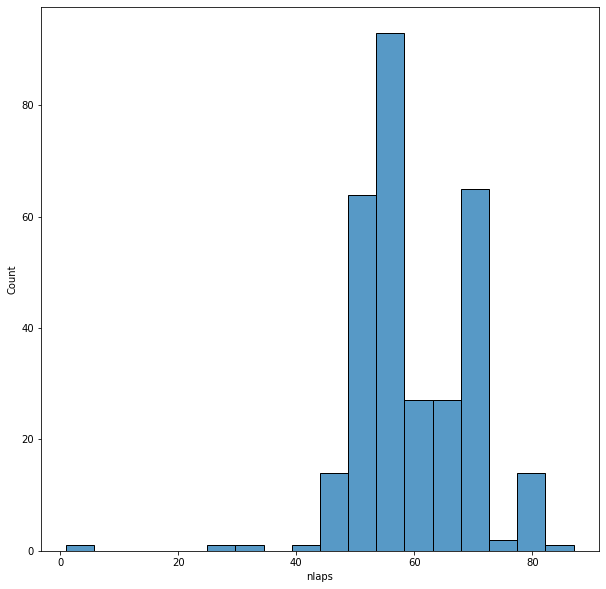

In [27]:
fig, ax = plt.subplots(figsize=(10,10))

laps_per_race = races.groupby('raceId')[['nlaps']].max().reset_index()
sns.histplot(data=laps_per_race, x='nlaps')

## Driver Placement IQR

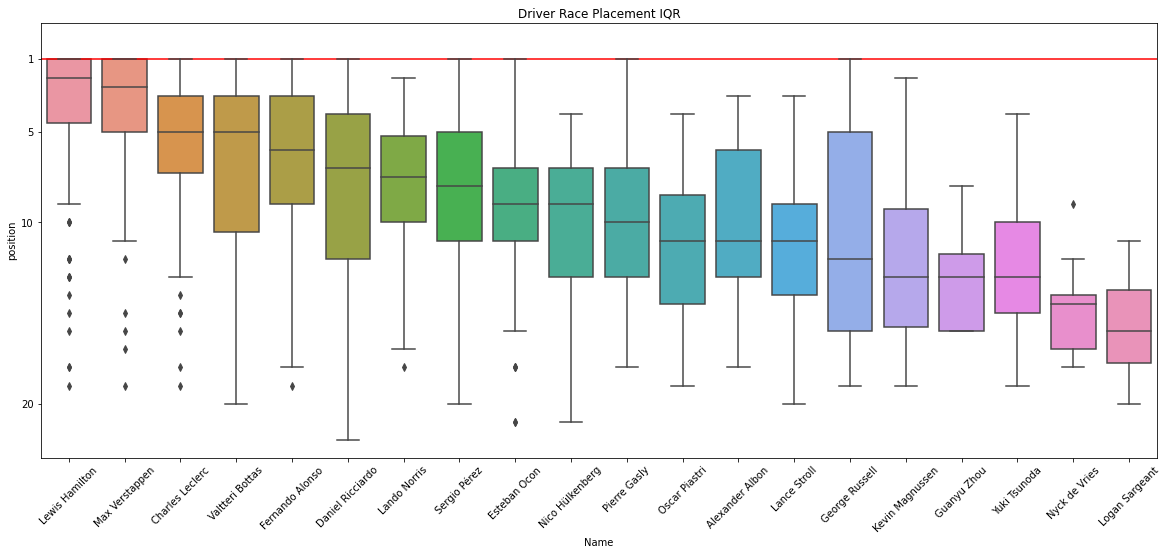

In [439]:
fig, ax = plt.subplots(figsize=(20, 8))
title = 'Driver Race Placement IQR'
plt.title(title)
plt.axhline(y=1, color='r', linestyle='-')

driver_median_positions = races.groupby('Name')['position'].median().sort_values().index
sns.boxplot(data=races, x='Name', y='position', order=driver_median_positions)
# tilt x axis labels
plt.xticks(rotation=45)
plt.yticks([1, 5, 10, 20, 25])
plt.ylim(23, -1)
plt.savefig(f'eda_visualizations/{title}.png')

## Driver Imbalance

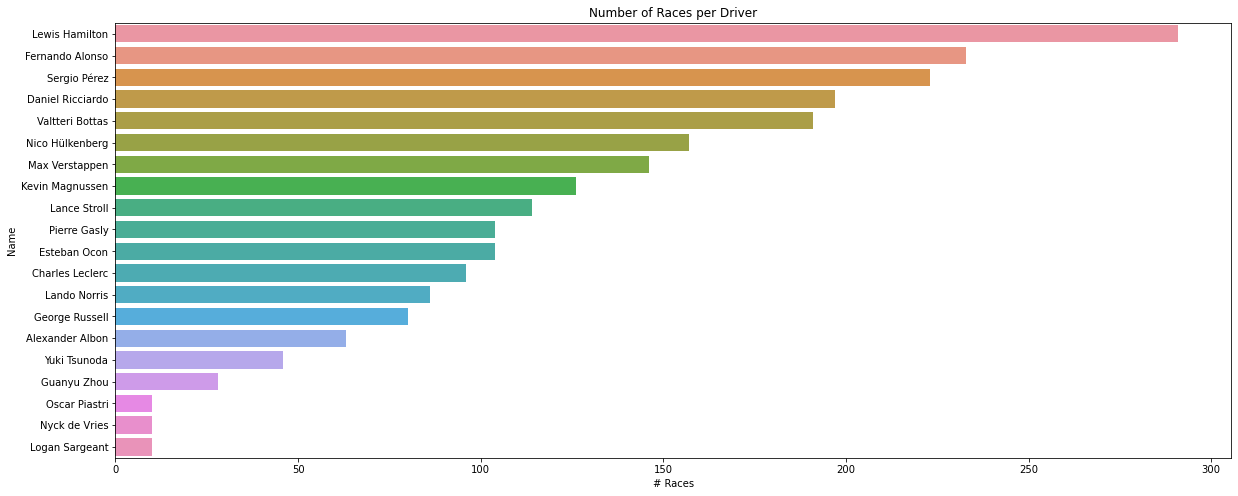

In [440]:
fig, ax = plt.subplots(figsize=(20, 8))
title = 'Number of Races per Driver'
plt.title(title)
driver_n_races = races.groupby('Name').size().sort_values(ascending=False).reset_index(name='# Races')

sns.barplot(data=driver_n_races, x='# Races', y='Name')

plt.savefig(f'eda_visualizations/{title}.png')

# Models

In [28]:
model_data = races.copy(deep=True)
X, y = model_data.drop(['position'], axis=1), model_data['position']

X.drop(['raceId','resultId','positionText','points','status','lat','lng','location','country','Race','Circuit'], axis=1, inplace=True)
X

,grid,Name,Car,round,alt,Month,Year,nlaps
0,1,Lewis Hamilton,McLaren,1,10,3,2008,58
1,11,Fernando Alonso,Renault,1,10,3,2008,58
2,9,Lewis Hamilton,McLaren,2,18,3,2008,56
3,7,Fernando Alonso,Renault,2,18,3,2008,56
4,10,Fernando Alonso,Renault,3,7,4,2008,57
...,...,...,...,...,...,...,...,...
2310,15,Alexander Albon,Williams,12,401,7,2023,44
2311,16,Kevin Magnussen,Haas F1 Team,12,401,7,2023,44
2312,19,Daniel Ricciardo,AlphaTauri,12,401,7,2023,44
2313,18,Logan Sargeant,Williams,12,401,7,2023,44


In [31]:
def driver_only_linear(data, y):
    data = data['Name']
    data = pd.get_dummies(data, columns=['Name'], drop_first=False)
    X = data.values

    #y = (y == 1).astype(int)

    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    #return coef
    weights = pd.DataFrame([coef], columns=data.columns)


    return weights

baseline_coef = driver_only_linear(X, y)
baseline_coef

,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,Kevin Magnussen,Lance Stroll,Lando Norris,Lewis Hamilton,Logan Sargeant,Max Verstappen,Nico Hülkenberg,Nyck de Vries,Oscar Piastri,Pierre Gasly,Sergio Pérez,Valtteri Bottas,Yuki Tsunoda
0,10.079365,6.010417,8.324873,9.375,6.656652,10.575,13.107143,12.365079,11.122807,8.139535,3.446735,15.9,3.787671,9.910828,14.8,11.2,9.894231,8.130045,6.732984,12.478261


In [32]:
def model2(data, y):
    data = data[['Name','grid','Car','alt','Month','Year','nlaps']]
    data = data[['Name','grid','alt','nlaps']]
    data = pd.get_dummies(data, columns=['Name'], drop_first=False, prefix='', prefix_sep='')
    #data = pd.get_dummies(data, columns=['Car'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Month'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Year'], drop_first=False)
    mm = MinMaxScaler()
    data[['grid','alt','nlaps']] = mm.fit_transform(data[['grid','alt','nlaps']])
    display(data)
    X = data.values

    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    #return coef
    weights = pd.DataFrame([coef], columns=data.columns)


    return weights

coef2 = model2(X, y)
coef2

,grid,alt,nlaps,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,...,Lewis Hamilton,Logan Sargeant,Max Verstappen,Nico Hülkenberg,Nyck de Vries,Oscar Piastri,Pierre Gasly,Sergio Pérez,Valtteri Bottas,Yuki Tsunoda
0,0.041667,0.007610,0.662791,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.458333,0.007610,0.662791,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.375000,0.011191,0.639535,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0.291667,0.011191,0.639535,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.416667,0.006267,0.651163,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,0.625000,0.182632,0.500000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2311,0.666667,0.182632,0.500000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2312,0.791667,0.182632,0.500000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313,0.750000,0.182632,0.500000,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


,grid,alt,nlaps,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,...,Lewis Hamilton,Logan Sargeant,Max Verstappen,Nico Hülkenberg,Nyck de Vries,Oscar Piastri,Pierre Gasly,Sergio Pérez,Valtteri Bottas,Yuki Tsunoda
0,10.537935,0.176569,0.006554,5.245542,3.038626,4.096786,4.599312,2.998979,5.566034,6.997814,...,1.706806,8.243194,1.466201,5.476202,8.813218,6.74922,5.311511,3.912027,3.736803,7.055785


In [62]:
def model3(data, y):
    data = data[['Name','grid','Car','alt','Month','Year','nlaps']]
    data = data[['Name','alt','nlaps']]
    data = pd.get_dummies(data, columns=['Name'], drop_first=False, prefix='', prefix_sep='')
    #data = pd.get_dummies(data, columns=['Car'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Month'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Year'], drop_first=False)
    mm = MinMaxScaler()
    data[['alt','nlaps']] = mm.fit_transform(data[['alt','nlaps']])
    #display(data)
    X = data.values

    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    #return coef
    weights = pd.DataFrame([coef], columns=data.columns)


    return weights

coef3 = model3(X, y)
coef3

,alt,nlaps,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,Kevin Magnussen,...,Lewis Hamilton,Logan Sargeant,Max Verstappen,Nico Hülkenberg,Nyck de Vries,Oscar Piastri,Pierre Gasly,Sergio Pérez,Valtteri Bottas,Yuki Tsunoda
0,0.287147,-0.147783,10.148917,6.074689,8.397012,9.440643,6.731992,10.642137,13.175437,12.43508,...,3.520616,15.978425,3.852863,9.98445,14.886051,11.28681,9.958601,8.2023,6.80228,12.551353


In [77]:
def lasso1(data, y):
    data = data[['Name','grid','Car','alt','Month','Year','nlaps']]
    data = data[['Name','grid','alt','nlaps']]
    data = pd.get_dummies(data, columns=['Name'], drop_first=False, prefix='', prefix_sep='')
    #data = pd.get_dummies(data, columns=['Car'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Month'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Year'], drop_first=False)
    mm = MinMaxScaler()
    data[['grid','alt','nlaps']] = mm.fit_transform(data[['grid','alt','nlaps']])
    #display(data)
    X = data.values

    linreg = Lasso(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    #return coef
    weights = pd.DataFrame([coef], columns=data.columns)


    return weights

lasso1_coef = lasso1(X, y)
lasso1_coef

,grid,alt,nlaps,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,...,Lewis Hamilton,Logan Sargeant,Max Verstappen,Nico Hülkenberg,Nyck de Vries,Oscar Piastri,Pierre Gasly,Sergio Pérez,Valtteri Bottas,Yuki Tsunoda
0,6.092734,0.0,6.00729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
def ridge1(data, y):
    data = data[['Name','Car','alt','Month','Year','nlaps']]
    data = data[['Name','alt','nlaps','Car']]
    data = pd.get_dummies(data, columns=['Name','Car'], drop_first=False, prefix='', prefix_sep='')
    #data = pd.get_dummies(data, columns=['Car'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Month'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Year'], drop_first=False)
    mm = MinMaxScaler()
    data[['alt','nlaps']] = mm.fit_transform(data[['alt','nlaps']])
    #display(data)
    X = data.values

    linreg = Ridge(fit_intercept=False, alpha=0.1)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    #return coef
    weights = pd.DataFrame([coef], columns=data.columns)


    return weights

ridge1_coef = ridge1(X, y)
ridge1_coef

,alt,nlaps,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,Kevin Magnussen,...,Haas F1 Team,Manor Marussia,McLaren,Mercedes,Racing Point,Red Bull,Renault,Sauber,Toro Rosso,Williams
0,0.167336,0.197414,5.379682,4.553442,4.463187,3.95479,3.395014,5.292592,2.994127,6.183439,...,6.615737,12.740993,4.708258,1.903623,3.74154,0.58626,4.237595,5.239671,6.806325,7.26567


In [70]:
def plot_driver_weight_change(weights1, weights2, title='Driver Weights Change', model1name=None, model2name=None, save=False):
    # weights1 = baseline_coef
    # weights2 = coef
    weights1 = weights1[[c for c in weights1.columns if c in driver_names_of_interest]].copy()
    #weights1.rename(index={0:'baseline'}, inplace=True)
    weights2 = weights2[[c for c in weights2.columns if c in driver_names_of_interest]].copy()
    #print(weights2)
    #weights2.rename(index={0:'baseline'}, inplace=True)

    assert len(weights1) == len(weights2)

    weights1 = weights1.T.reset_index()
    weights1.columns = ['Driver','Model1']
    weights1['Model1'] = weights1['Model1'] / max(weights1['Model1'].sum(), 0.00001)

    weights2 = weights2.T.reset_index()
    weights2.columns = ['Driver','Model2']
    weights2['Model2'] = weights2['Model2'] / max(weights2['Model2'].sum(),0.00001)
    #print(weights2)


    weights = weights1.merge(weights2, on='Driver')
    #print(weights)

    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=38)
    plt.xlabel('Model 1')
    plt.ylabel('Model 2')
    xmin = weights1['Model1'].min()
    xmax = weights1['Model1'].max()
    x = np.linspace(xmin, xmax,100)
    y = x
    # plt.xlim(xmin-0.02, xmax+0.02)
    # plt.ylim(xmin-0.02, xmax+0.02)
    plt.xlim(xmin-0.005, xmax+0.005)
    plt.ylim(xmin-0.011, xmax+0.011)

    plt.plot(x, y, 'blue', label='y=x')

    weights = weights.sort_values(by='Model1', ascending=False)

    for row in range(0,weights.shape[0]):
        sub = weights.iloc[row:row+1].melt(id_vars=['Driver'])
        #print(sub)
        weight_increased = sub[sub['variable']=='Model1']['value'].squeeze() > sub[sub['variable']=='Model2']['value'].squeeze()
        marker_dict = {True: 'v', False: '^'}
        sub = sub[sub['variable'].isin(['Model1', 'Model2'])]
        sub['Model1'] = sub[sub['variable']=='Model1']['value'].squeeze()
        color_dict = {True:'green', False:'red'}
        lp = sns.lineplot(data=sub, x='Model1', y='value', color= color_dict[weight_increased],linewidth = 3, estimator=None) # hue_order=['preds_no_age','preds_age'], palette=['#99ADE9', '#EFCB99'])
        sp = sns.scatterplot(data=sub, x='Model1', y='value',marker=marker_dict[weight_increased], s=100, color=color_dict[weight_increased]) #, hue='variable',hue_order=['Parent SNAP Baseline','Parent SNAP Endpoint'], palette=['#ECA985','#D25613'], marker=marker_dict[decreased])
        
        #print(sub.loc[0,'value'].squeeze())
        start_x = sub.loc[0,'value'].squeeze()
        start_y = (sub.loc[0,'value'].squeeze() + sub.loc[1,'value'].squeeze())/2

        #end_y = start_y + 0.01 if row % 2 == 0 else start_y - 0.01
        end_y = start_y - 0.01 if weight_increased else start_y + 0.01

        plt.annotate(sub['Driver'].values[0], (start_x, start_y), xytext=(start_x, end_y),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', fc=color_dict[weight_increased]),fontsize=16)
        plt.legend([],[], frameon=False)
    
    plt.savefig(f'eda_visualizations/{title}.png')
        

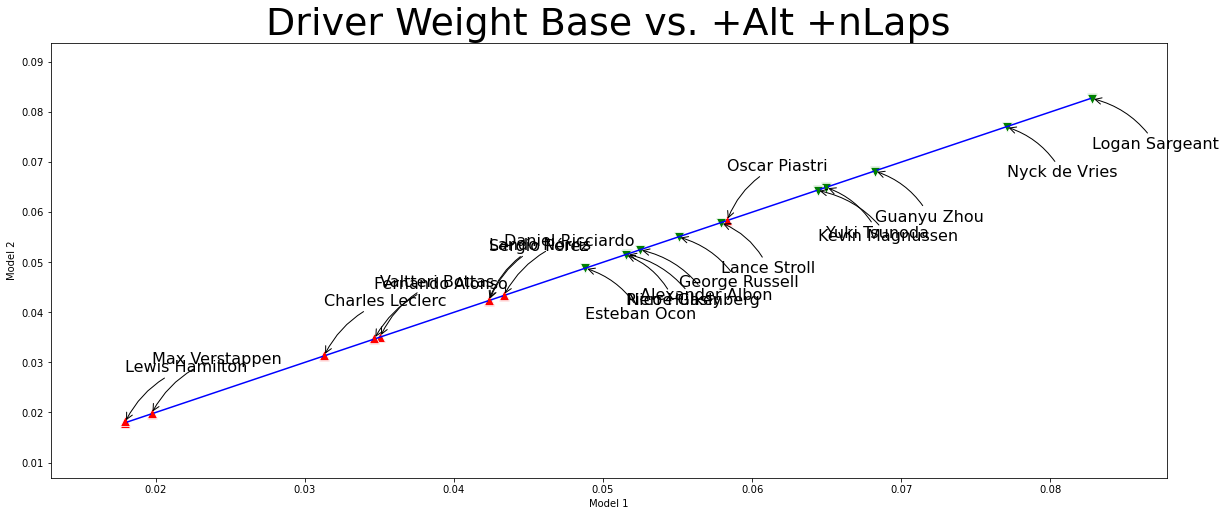

In [71]:
plot_driver_weight_change(baseline_coef, coef3, title='Driver Weight Base vs. +Alt +nLaps', model1name='Baseline', model2name='Altitude + nLaps', save=True)

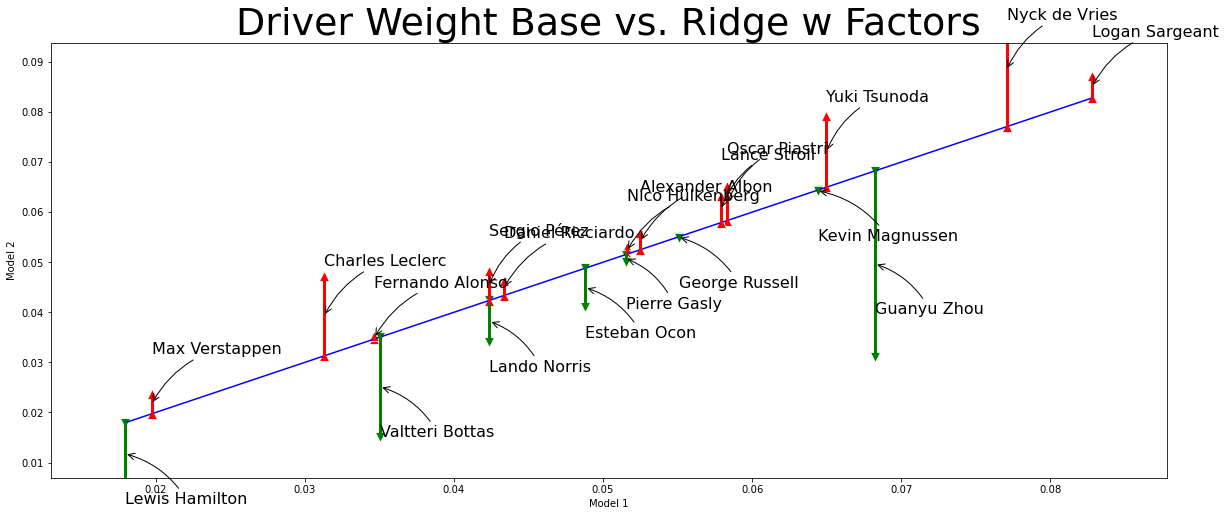

In [75]:
plot_driver_weight_change(baseline_coef, ridge1_coef, title='Driver Weight Base vs. Ridge w Factors', model1name='Baseline', model2name='Ridge', save=True)

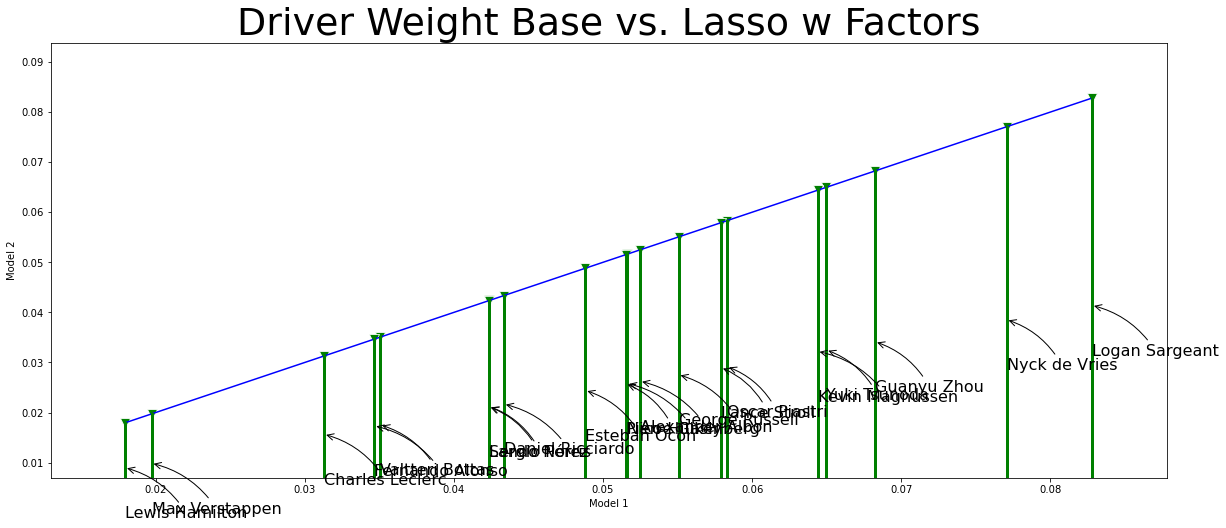

In [78]:
plot_driver_weight_change(baseline_coef, lasso1_coef, title='Driver Weight Base vs. Lasso w Factors', model1name='Baseline', model2name='Lasso', save=True)

# Appendix

## results_raw_df

In [59]:
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')
# position and position order are the same
assert sum(results_raw_df['position'] == results_raw_df['positionOrder']) == 0

print(results_raw_df.loc[results_raw_df['position'] != results_raw_df['positionText'], 'position'].unique())
print(results_raw_df.loc[results_raw_df['position'] != results_raw_df['positionText'], 'positionText'].unique())

[nan]
['R' 'D' 'N' '11' '14' 'W' 'F' 'E']


## Race data has missing values for time

In [49]:
kaggle_race_data = load_kaggle_data(f'{data_dir}/races.csv')
assert kaggle_race_data.shape[0] == kaggle_race_data['raceId'].nunique(), 'confirm no duplicates'
kaggle_race_data.rename(columns={'name':'Race'}, inplace=True)
kaggle_race_data = kaggle_race_data[['raceId','Race','year','round','circuitId','date','time']]
kaggle_race_data.isna().sum()

raceId         0
Race           0
year           0
round          0
circuitId      0
date           0
time         731
dtype: int64

## Use driverId not number

In [42]:
races_raw_df = load_kaggle_data(f'{data_dir}/races.csv')
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')

raceiddriver = races_raw_df[['raceId','year']].merge(results_raw_df[['raceId','number','driverId']], on='raceId', how='left')
#raceiddriver = races_raw_df[races_raw_df['year']==races_raw_df['year'].min()][['raceId','year']].merge(results_raw_df[['raceId','number','driverId']], on='raceId', how='left')
#raceiddriver = raceiddriver[raceiddriver['raceId']==833].reset_index(drop=True)
raceiddriver = raceiddriver.merge(drivers[['driverId','number','Name']], on='number', how='left')
#raceiddriver['Name'].nunique()
raceiddriver.sort_values(by='Name')

assert raceiddriver.groupby(['Name'])['driverId_y'].nunique().max() == 1 # driverID is unique to driver name
#raceiddriver.groupby(['Name'])['driverId_y'].nunique()


raceiddriver

In [43]:
raceiddriver

,raceId,year,number,driverId_x,driverId_y,Name
0,1,2009,22,18.0,18.0,Jenson Button
1,1,2009,22,18.0,852.0,Yuki Tsunoda
2,1,2009,23,22.0,848.0,Alexander Albon
3,1,2009,9,15.0,828.0,Marcus Ericsson
4,1,2009,9,15.0,853.0,Nikita Mazepin
...,...,...,...,...,...,...
45834,1120,2023,NaN,NaN,812.0,Karun Chandhok
45835,1120,2023,NaN,NaN,814.0,Paul di Resta
45836,1120,2023,NaN,NaN,816.0,Jérôme d'Ambrosio
45837,1120,2023,NaN,NaN,819.0,Charles Pic


raceiddriver